In [1]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


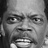

In [3]:
# loading a sample image
sample_image = Image.open("/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/angry/10.jpg")
sample_image

In [4]:
np.array(sample_image).shape

(48, 48)

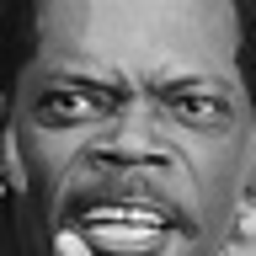

In [5]:
sample_image = sample_image.resize([256,256])
sample_image

In [6]:
np.array(sample_image).shape

(256, 256)

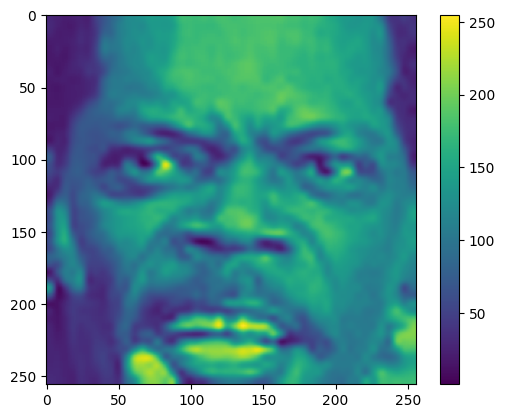

In [8]:
plt.imshow(np.array(sample_image))
plt.colorbar()
plt.show()

## Extract only face from images

In [9]:
from google.colab.patches import cv2_imshow

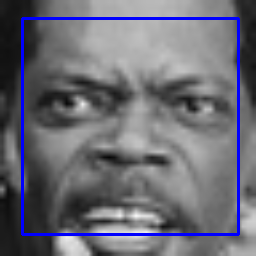

In [17]:
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/angry/10.jpg')
img = cv2.resize(img, dsize=(256,256))
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cropped_img= img[x:x+w, y:y+h]
    cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
    # Display the output
cv2_imshow(img)

In [18]:
cropped_img.shape

(256, 256, 3)

In [19]:
cropped_img = cropped_img.sum(axis=2)

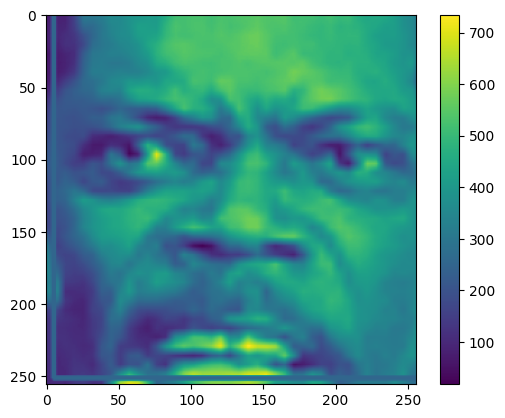

In [20]:
plt.imshow(cropped_img)
plt.colorbar()

## Load Data and Extract only Face

In [21]:
import cv2

In [22]:
def load_extract_normalize(image_path, normalized=True):
    # Read the input image and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(256,256))
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # crop faces
    for (x, y, w, h) in faces:
        cropped_img= img[x:x+w, y:y+h].astype('float32')
        cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
        cropped_img = cropped_img.sum(axis=2)

    if normalized:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32) / 255.0
        else:
          return np.array(img).astype(np.float32) / 255.0
    else:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32)
        else:
          return np.array(img).astype(np.float32)

In [74]:
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([128,128])
    image = np.array(image).astype(np.float32)
    if len(image.shape) == 3:
        image = image.sum(axis=2)
    if normalized:
        return image / 255.0
    else:
        return image

In [24]:
# code to load all the data, assuming dataset is at /content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [25]:
print(f"There are {len(x_data)} in total.")

There are 27546 in total.


In [ ]:
for i,emo in enumerate(emo_types):
  print(emo,":", y_data.count(i))

angry : 3977
disgust : 551
fear : 3867
happy : 7230
neutral : 4580
sad : 4696
surprise : 2645


(22036, 128, 128, 1) (22036, 7)
(5510, 128, 128, 1) (5510, 7)


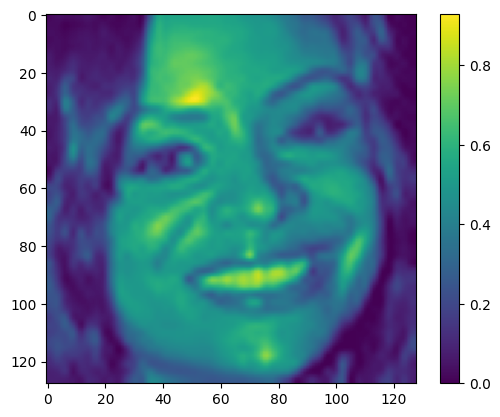

In [27]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()
plt.show()

## Base VGG16

In [28]:
VGG16_model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),

    # output layer:
    tf.keras.layers.Dense(7, activation='softmax')
])

In [29]:
VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [31]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [ ]:
n_epoch = 30
hist = VGG16_model.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 109s 129ms/step - loss: 1.8166 - categorical_accuracy: 0.2602 - val_loss: 1.7977 - val_categorical_accuracy: 0.2710
Epoch 2/30
689/689 [==============================] - 87s 126ms/step - loss: 1.7023 - categorical_accuracy: 0.3178 - val_loss: 1.5100 - val_categorical_accuracy: 0.4062
Epoch 3/30
689/689 [==============================] - 87s 126ms/step - loss: 1.4198 - categorical_accuracy: 0.4484 - val_loss: 1.3994 - val_categorical_accuracy: 0.4583
Epoch 4/30
689/689 [==============================] - 87s 126ms/step - loss: 1.2241 - categorical_accuracy: 0.5304 - val_loss: 1.2185 - val_categorical_accuracy: 0.5368
Epoch 5/30
689/689 [==============================] - 87s 127ms/step - loss: 1.0714 - categorical_accuracy: 0.5957 - val_loss: 1.1640 - val_categorical_accuracy: 0.5670
Epoch 6/30
689/689 [==============================] - 87s 127ms/step - loss: 0.9094 - categorical_accuracy: 0.6628 - val_loss: 1.1509 - val_categorical_ac

In [32]:
# run by wafi
n_epoch = 30
hist = VGG16_model.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 116s 139ms/step - loss: 1.8178 - categorical_accuracy: 0.2611 - val_loss: 1.8122 - val_categorical_accuracy: 0.2624
Epoch 2/30
689/689 [==============================] - 91s 133ms/step - loss: 1.6713 - categorical_accuracy: 0.3300 - val_loss: 1.5201 - val_categorical_accuracy: 0.4047
Epoch 3/30
689/689 [==============================] - 87s 127ms/step - loss: 1.3937 - categorical_accuracy: 0.4540 - val_loss: 1.3353 - val_categorical_accuracy: 0.4819
Epoch 4/30
689/689 [==============================] - 87s 127ms/step - loss: 1.2139 - categorical_accuracy: 0.5365 - val_loss: 1.2083 - val_categorical_accuracy: 0.5416
Epoch 5/30
689/689 [==============================] - 92s 134ms/step - loss: 1.0660 - categorical_accuracy: 0.5989 - val_loss: 1.1248 - val_categorical_accuracy: 0.5786
Epoch 6/30
689/689 [==============================] - 88s 127ms/step - loss: 0.9140 - categorical_accuracy: 0.6578 - val_loss: 1.1082 - val_categorical_ac

In [35]:
VGG16_model.save('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_model')

In [33]:
n_epoch = 9

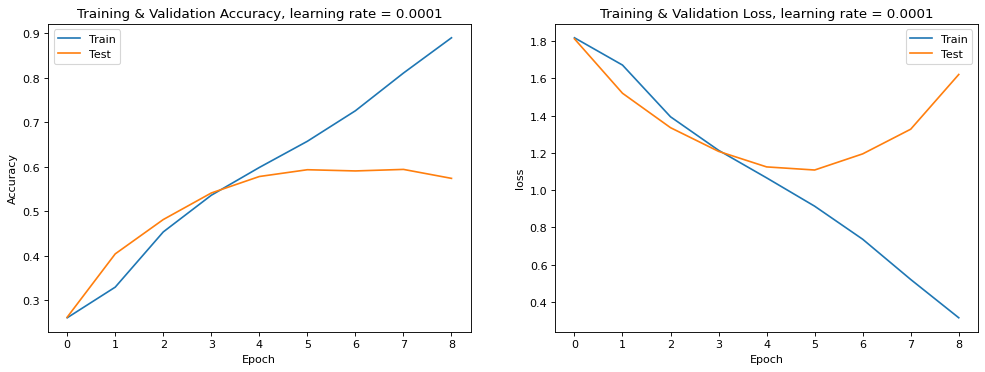

In [34]:
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

In [36]:
# Save the weights
VGG16_model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_modelVGG16_model')

### Test Model

In [37]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
x_test = []
y_test = []

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

(6488, 128, 128, 1) (6488, 7)


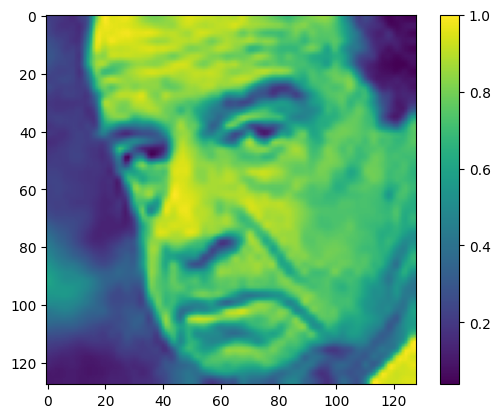

In [38]:
# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 128, 128, 1)
y_test = np.array(y_test)

# folder = StratifiedKFold(5, shuffle=True)
# x_indices = np.arange(0, len(x_data))
# train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# # shuffling
# np.random.shuffle(train_indices)

# x_train = x_data[train_indices]
# y_train = np.eye(len(emo_types))[y_data[train_indices]]
y_test = np.eye(len(emo_types))[y_test]

# x_val = x_data[val_indices]
# y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_test.shape, y_test.shape)

plt.imshow(x_test[0,:,:,0])
plt.colorbar()
plt.show()

In [ ]:
y_test = np.eye(len(emo_types))[y_test]

In [ ]:
# Evaluate the model
loss, acc = VGG16_model.evaluate(x_test, y_test, verbose=2)
print("VGG 16 model, accuracy: {:5.2f}%".format(100 * acc))

203/203 - 8s - loss: 1.7595 - categorical_accuracy: 0.5754 - 8s/epoch - 39ms/step
VGG 16 model, accuracy: 57.54%


In [ ]:
y_pred = VGG16_model.predict(x_test, verbose=2)

203/203 - 7s - 7s/epoch - 34ms/step


In [ ]:
y_pred = np.argmax(y_pred,axis = 1)

In [ ]:
y_test = np.argmax(y_test,axis = 1)

In [ ]:
y_test

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.42      0.46       888
           1       0.46      0.42      0.44        83
           2       0.41      0.41      0.41       916
           3       0.77      0.82      0.79      1752
           4       0.51      0.58      0.54      1181
           5       0.46      0.42      0.44      1088
           6       0.66      0.65      0.66       580

    accuracy                           0.58      6488
   macro avg       0.54      0.53      0.53      6488
weighted avg       0.57      0.58      0.57      6488



### Run by Wafi

In [41]:
# Evaluate the model - Run by wafi
loss, acc = VGG16_model.evaluate(x_test, y_test, verbose=2)
print("VGG 16 model, accuracy: {:5.2f}%".format(100 * acc))

203/203 - 7s - loss: 1.7275 - categorical_accuracy: 0.5617 - 7s/epoch - 33ms/step
VGG 16 model, accuracy: 56.17%


In [42]:
y_pred = VGG16_model.predict(x_test, verbose=2)

203/203 - 7s - 7s/epoch - 33ms/step


In [43]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.45      0.48      0.47       888
           1       0.38      0.33      0.35        83
           2       0.40      0.32      0.36       916
           3       0.81      0.80      0.81      1752
           4       0.52      0.52      0.52      1181
           5       0.40      0.53      0.46      1088
           6       0.76      0.52      0.62       580

    accuracy                           0.56      6488
   macro avg       0.53      0.50      0.51      6488
weighted avg       0.57      0.56      0.56      6488



Seems overfitted. Next step is try to reduce overfitting.

## Batch Normalisation and Drop Out

In [44]:
VGG16_model_bn = tf.keras.models.Sequential([
    
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Batch Normalisation layer:
    tf.keras.layers.BatchNormalization(),


    # output layer:
    tf.keras.layers.Dense(7, activation='softmax')
])

In [45]:
VGG16_model_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [ ]:
n_epoch = 30
hist = VGG16_model_bn.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 112s 152ms/step - loss: 1.9995 - categorical_accuracy: 0.2967 - val_loss: 1.7099 - val_categorical_accuracy: 0.3365
Epoch 2/30
689/689 [==============================] - 104s 151ms/step - loss: 1.5659 - categorical_accuracy: 0.4227 - val_loss: 1.2998 - val_categorical_accuracy: 0.4895
Epoch 3/30
689/689 [==============================] - 104s 151ms/step - loss: 1.2972 - categorical_accuracy: 0.5136 - val_loss: 1.2421 - val_categorical_accuracy: 0.5307
Epoch 4/30
689/689 [==============================] - 104s 151ms/step - loss: 1.1496 - categorical_accuracy: 0.5704 - val_loss: 1.2021 - val_categorical_accuracy: 0.5528
Epoch 5/30
689/689 [==============================] - 104s 151ms/step - loss: 1.0357 - categorical_accuracy: 0.6187 - val_loss: 1.1594 - val_categorical_accuracy: 0.5721
Epoch 6/30
689/689 [==============================] - 104s 151ms/step - loss: 0.9321 - categorical_accuracy: 0.6566 - val_loss: 1.1199 - val_categoric

In [46]:
# Run by Wafi
n_epoch = 30
hist = VGG16_model_bn.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 125s 158ms/step - loss: 2.0031 - categorical_accuracy: 0.2865 - val_loss: 1.9775 - val_categorical_accuracy: 0.3256
Epoch 2/30
689/689 [==============================] - 104s 151ms/step - loss: 1.5957 - categorical_accuracy: 0.4141 - val_loss: 1.3680 - val_categorical_accuracy: 0.4809
Epoch 3/30
689/689 [==============================] - 108s 156ms/step - loss: 1.3146 - categorical_accuracy: 0.5063 - val_loss: 1.2442 - val_categorical_accuracy: 0.5169
Epoch 4/30
689/689 [==============================] - 104s 151ms/step - loss: 1.1712 - categorical_accuracy: 0.5643 - val_loss: 1.1290 - val_categorical_accuracy: 0.5771
Epoch 5/30
689/689 [==============================] - 107s 156ms/step - loss: 1.0471 - categorical_accuracy: 0.6117 - val_loss: 1.1692 - val_categorical_accuracy: 0.5706
Epoch 6/30
689/689 [==============================] - 104s 151ms/step - loss: 0.9628 - categorical_accuracy: 0.6498 - val_loss: 1.2766 - val_categoric

In [49]:
n_epoch=10

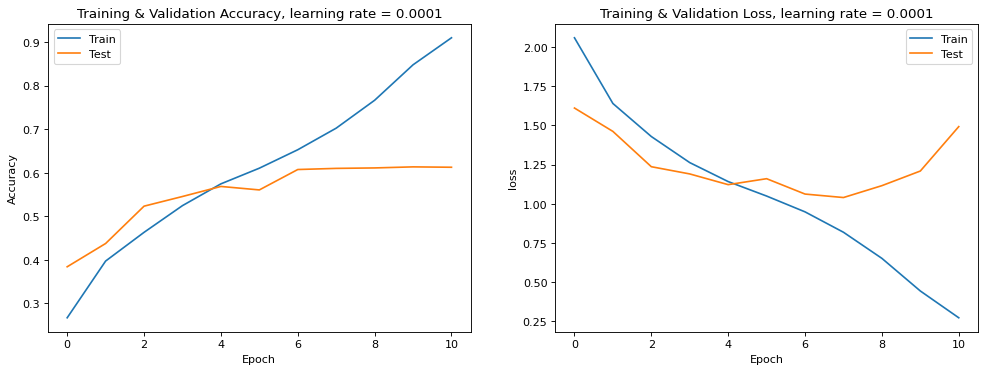

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

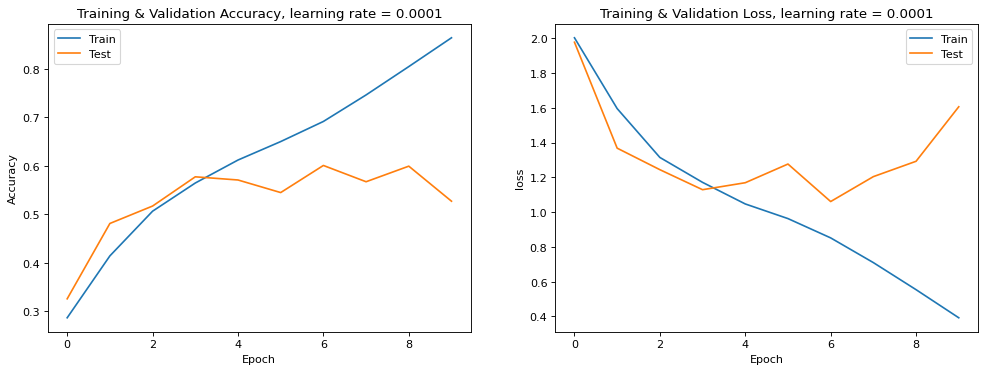

In [50]:
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

In [51]:
VGG16_model_bn.save('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_model_bn')

In [52]:
# Save the weights
VGG16_model_bn.save_weights('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_model_bn')

In [58]:
y_test = np.eye(len(emo_types))[y_test]

In [ ]:
# Evaluate the model
loss, acc = VGG16_model_bn.evaluate(x_test, y_test, verbose=2)
print("VGG 16 model, accuracy: {:5.2f}%".format(100 * acc))

203/203 - 8s - loss: 1.4099 - categorical_accuracy: 0.5825 - 8s/epoch - 40ms/step
VGG 16 model, accuracy: 58.25%


In [ ]:
y_pred = VGG16_model_bn.predict(x_test, verbose=2)

203/203 - 8s - 8s/epoch - 39ms/step


In [ ]:
y_pred = np.argmax(y_pred,axis = 1)

In [ ]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
y_test = np.argmax(y_test,axis = 1)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.47      0.56      0.51       888
           1       0.62      0.22      0.32        83
           2       0.37      0.42      0.39       916
           3       0.85      0.80      0.82      1752
           4       0.58      0.52      0.55      1181
           5       0.45      0.44      0.45      1088
           6       0.68      0.67      0.68       580

    accuracy                           0.58      6488
   macro avg       0.57      0.52      0.53      6488
weighted avg       0.59      0.58      0.59      6488



### Run by Wafi

In [59]:
# Evaluate the model - Run by wafi
loss, acc = VGG16_model_bn.evaluate(x_test, y_test, verbose=2)
print("VGG 16 model, accuracy: {:5.2f}%".format(100 * acc))

203/203 - 8s - loss: 1.6577 - categorical_accuracy: 0.5205 - 8s/epoch - 37ms/step
VGG 16 model, accuracy: 52.05%


In [60]:
y_pred = VGG16_model_bn.predict(x_test, verbose=2)

203/203 - 7s - 7s/epoch - 37ms/step


In [61]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.46      0.48       888
           1       0.45      0.11      0.17        83
           2       0.38      0.41      0.39       916
           3       0.89      0.62      0.73      1752
           4       0.63      0.40      0.49      1181
           5       0.36      0.72      0.48      1088
           6       0.49      0.41      0.45       580

    accuracy                           0.52      6488
   macro avg       0.53      0.45      0.46      6488
weighted avg       0.59      0.52      0.53      6488



# VGG16 non BN + DO

1/1 [==============================] - 0s 31ms/step


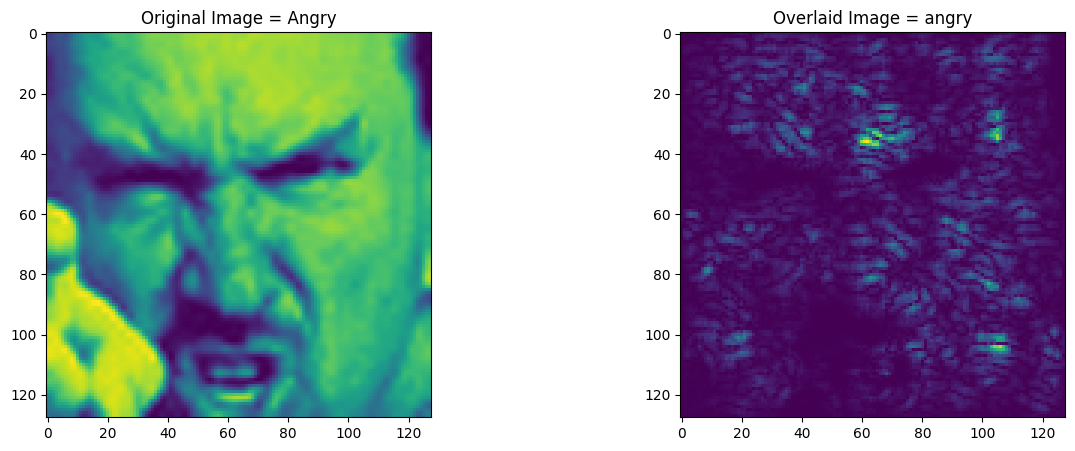

In [78]:
# create saliency map for one image from the angry folder in validation_relabeled folder
img = load_normalize('/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned/angry/3137.jpg')
img = img.reshape(-1, 128, 128, 1)
img = tf.convert_to_tensor(img)

# create a function to get the saliency map
def get_saliency_map(img, model):
    with tf.GradientTape() as tape:
        tape.watch(img)
        pred = model(img)
        loss = pred[:, 0]
    # get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, img)
    # get the absolute values of the gradients
    abs_grads = tf.abs(gradient)
    # get the maximum value in each dimension (row, column, channel)
    max_val = tf.reduce_max(abs_grads, axis=(1, 2, 3))
    # get the saliency map by normalizing the gradients with the maximum value
    saliency_map = abs_grads / max_val[:, None, None, None]
    return saliency_map

# get the saliency map
saliency_map = get_saliency_map(img, VGG16_model)

# overlay the saliency map on the original image
def overlay_saliency_map(img, saliency_map):
    # get the original image
    original_img = img[0]
    # get the saliency map
    saliency_map = saliency_map[0]
    # resize the saliency map to the size of the original image
    saliency_map = tf.image.resize(saliency_map, (128, 128))
    # overlay the saliency map on the original image
    overlaid_img = saliency_map * original_img
    return overlaid_img

# get the overlaid image
overlaid_img = overlay_saliency_map(img, saliency_map)

# change the overlaid image to numpy array
overlaid_img = overlaid_img.numpy()

# The label of original image
pred = VGG16_model.predict(img)
pred = np.argmax(pred)
pred_name = emo_types[pred]
# keep only words after the underscore
# pred_name = pred_name.split('_')[1]

# plot the original image and the overlaid image with each prediction
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img[0,:,:,0])
ax[0].set_title('Original Image = Angry')
ax[1].imshow(overlaid_img)
# set the transparency of the overlaid image
ax[1].set_alpha(0.1)
ax[1].set_title('Overlaid Image = ' + pred_name)
plt.show()

# VGG BN + DO

1/1 [==============================] - 0s 22ms/step


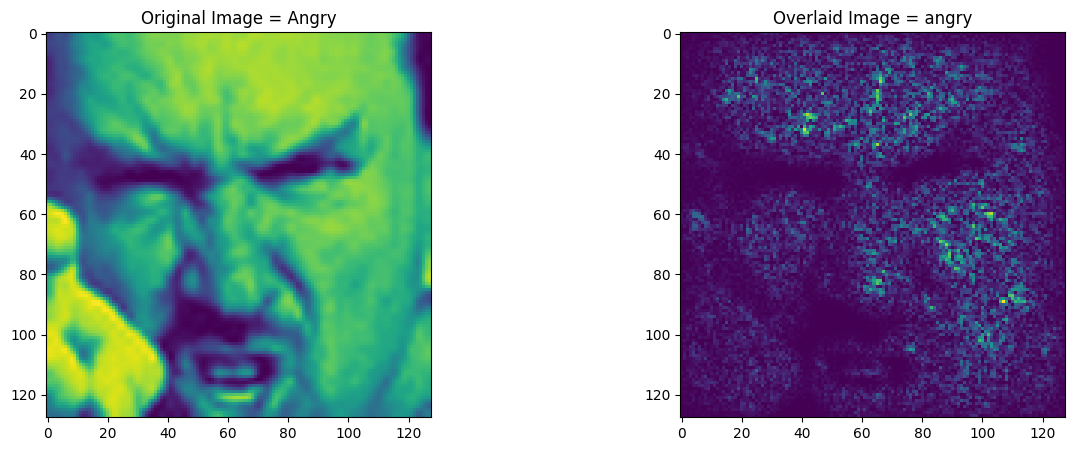

In [77]:
# create saliency map for one image from the angry folder in validation_relabeled folder
img = load_normalize('/content/gdrive/MyDrive/Expression Dataset/Validation_Relabeled_Cleaned/angry/3137.jpg')
img = img.reshape(-1, 128, 128, 1)
img = tf.convert_to_tensor(img)

# create a function to get the saliency map
def get_saliency_map(img, model):
    with tf.GradientTape() as tape:
        tape.watch(img)
        pred = model(img)
        loss = pred[:, 0]
    # get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, img)
    # get the absolute values of the gradients
    abs_grads = tf.abs(gradient)
    # get the maximum value in each dimension (row, column, channel)
    max_val = tf.reduce_max(abs_grads, axis=(1, 2, 3))
    # get the saliency map by normalizing the gradients with the maximum value
    saliency_map = abs_grads / max_val[:, None, None, None]
    return saliency_map

# get the saliency map
saliency_map = get_saliency_map(img, VGG16_model_bn)

# overlay the saliency map on the original image
def overlay_saliency_map(img, saliency_map):
    # get the original image
    original_img = img[0]
    # get the saliency map
    saliency_map = saliency_map[0]
    # resize the saliency map to the size of the original image
    saliency_map = tf.image.resize(saliency_map, (128, 128))
    # overlay the saliency map on the original image
    overlaid_img = saliency_map * original_img
    return overlaid_img

# get the overlaid image
overlaid_img = overlay_saliency_map(img, saliency_map)

# change the overlaid image to numpy array
overlaid_img = overlaid_img.numpy()

# The label of original image
pred = VGG16_model_bn.predict(img)
pred = np.argmax(pred)
pred_name = emo_types[pred]
# keep only words after the underscore
# pred_name = pred_name.split('_')[1]

# plot the original image and the overlaid image with each prediction
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img[0,:,:,0])
ax[0].set_title('Original Image = Angry')
ax[1].imshow(overlaid_img)
# set the transparency of the overlaid image
ax[1].set_alpha(0.1)
ax[1].set_title('Overlaid Image = ' + pred_name)
plt.show()